### This Notebook explains how we can solve a Malware Classification problem

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)


In [3]:
# ------------------------------------------------------
# 1. Generate synthetic dataset
# ------------------------------------------------------
np.random.seed(42)
n_samples = 200

# Feature 1: file_size (KB) - log-normal distribution to simulate varying sizes
file_size = np.random.lognormal(mean=5, sigma=1, size=n_samples)

# Feature 2: permissions (encoded as integer: 0=read-only, 1=read-write, 2=executable)
permissions = np.random.choice([0, 1, 2], size=n_samples, p=[0.4, 0.4, 0.2])

# Feature 3: entropy - uniform between 1 and 8 bits per byte
entropy = np.random.uniform(1, 8, n_samples)

# Feature 4: num_imports - number of imported library calls (Poisson)
num_imports = np.random.poisson(lam=10, size=n_samples)

# Combine features into DataFrame
df_cls = pd.DataFrame({
    "file_size": file_size,
    "permissions": permissions,
    "entropy": entropy,
    "num_imports": num_imports,
})

# Target: malware (1) or benign (0)
# We'll assume higher entropy, executable, many imports → more likely malware
malware_prob = (
    0.3 * (entropy / entropy.max()) +
    0.3 * (permissions == 2).astype(float) +
    0.3 * (num_imports / num_imports.max()) +
    0.1 * np.random.rand(n_samples)
)
y = (malware_prob > 0.5).astype(int)
df_cls["malware"] = y

In [4]:
# ------------------------------------------------------
# 2. Inspect the data
# ------------------------------------------------------
print("First 5 rows of the dataset:")
print(df_cls.head(), "\n")

print("Feature descriptions:")
print("- file_size: Size of file in KB (log-normal distribution).")
print("- permissions: 0=read-only, 1=read-write, 2=executable.")
print("- entropy: Measure of randomness in file content (1-8 bits/byte).")
print("- num_imports: Number of imported library calls.")
print("- malware: Target label (1=malicious, 0=benign).\n")

print("Class distribution:")
print(df_cls["malware"].value_counts(normalize=True), "\n")

First 5 rows of the dataset:
    file_size  permissions   entropy  num_imports  malware
0  243.889232            2  7.735208            5        1
1  129.248344            1  3.624094            7        0
2  283.635096            1  2.999985            7        0
3  680.637498            1  7.080194            5        0
4  117.430495            0  2.565171           13        0 

Feature descriptions:
- file_size: Size of file in KB (log-normal distribution).
- permissions: 0=read-only, 1=read-write, 2=executable.
- entropy: Measure of randomness in file content (1-8 bits/byte).
- num_imports: Number of imported library calls.
- malware: Target label (1=malicious, 0=benign).

Class distribution:
malware
0    0.715
1    0.285
Name: proportion, dtype: float64 



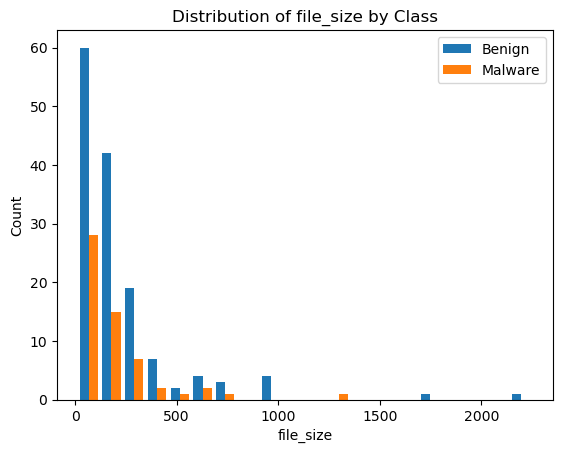

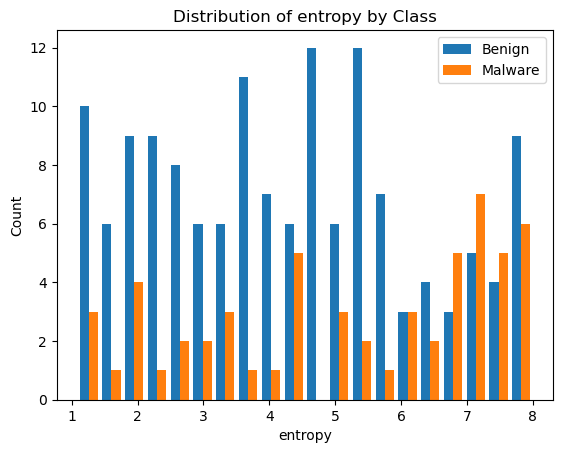

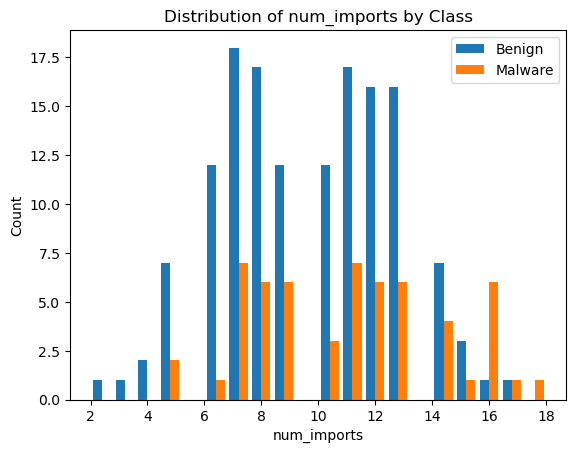

In [5]:
# ------------------------------------------------------
# 3. Visualize feature distributions by class
# ------------------------------------------------------
for feature in ["file_size", "entropy", "num_imports"]:
    plt.figure()
    plt.hist(
        [df_cls[df_cls["malware"]==0][feature], df_cls[df_cls["malware"]==1][feature]],
        bins=20,
        label=["Benign", "Malware"]
    )
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(f"Distribution of {feature} by Class")
    plt.legend()
    plt.show()

In [6]:
# ------------------------------------------------------
# 4. Train-test split
# ------------------------------------------------------
X = df_cls[["file_size", "permissions", "entropy", "num_imports"]]
y = df_cls["malware"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0], "\n")

Training samples: 150
Testing samples: 50 



In [7]:
# ------------------------------------------------------
# 5. Fit Decision Tree classifier
# ------------------------------------------------------
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

print("Decision tree trained with max_depth=4\n")

Decision tree trained with max_depth=4



In [8]:
# ------------------------------------------------------
# 6. Evaluate on test set
# ------------------------------------------------------
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1-score:", f1, "\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm, "\n")

Test Accuracy: 0.9
Test Precision: 0.8461538461538461
Test Recall: 0.7857142857142857
Test F1-score: 0.8148148148148148 

Confusion Matrix:
 [[34  2]
 [ 3 11]] 



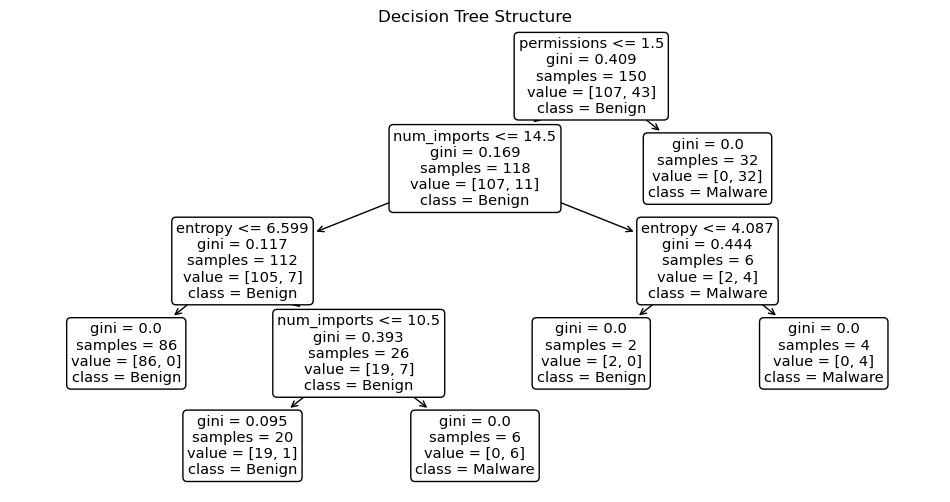

In [9]:
# ------------------------------------------------------
# 7. Plot the tree structure
# ------------------------------------------------------
plt.figure(figsize=(12,6))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["Benign", "Malware"],
    filled=False,
    rounded=True
)
plt.title("Decision Tree Structure")
plt.show()

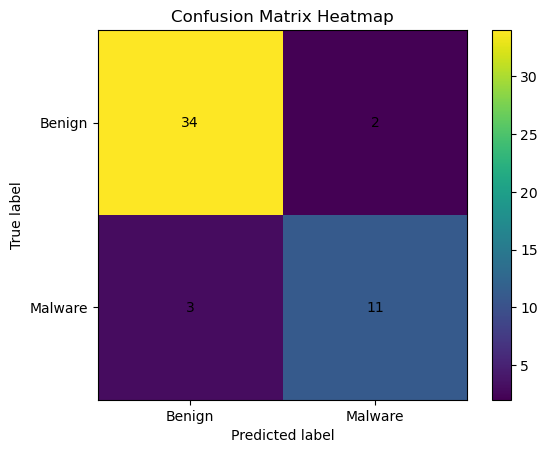

In [10]:
# ------------------------------------------------------
# 8. Confusion Matrix heatmap
# ------------------------------------------------------
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix Heatmap")
plt.colorbar()
tick_labels = ["Benign", "Malware"]
plt.xticks([0,1], tick_labels)
plt.yticks([0,1], tick_labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.show()

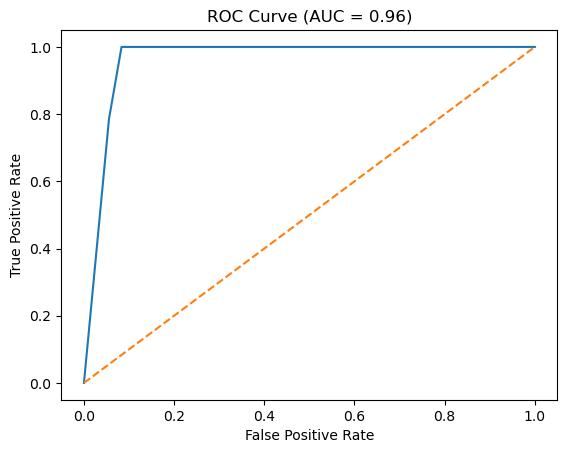

In [11]:
# ------------------------------------------------------
# 9. ROC Curve
# ------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.show()